Explore Features with Gradient Tree Boosting
============================================

There are roughly 30 features generated from the data cleaning script. This model will explore feature performance through training and tuning a gradient boosting classifier model.

In [12]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.ensemble as en
import sklearn.model_selection as mds
import matplotlib.pyplot as plt

from scipy import interpolate

datestamp = "20250215.112744"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 32)


In [13]:
#columns_to_drop = [ "Survived", "Name", "Title", "LastName", "Cabin", 
#                    "Ticket", "Sex", "Embarked", "Age", "PassengerId",
#                    "FarePerPerson", "AgeImputed", "Fare", "SexOrd" ]
#columns_to_drop += [ "AgeRobust", "FppMinMax", "TitleOrd" ]
#x_colnames = [i for i in df_.columns if i not in columns_to_drop]
x_colnames = [ "Mr", "Miss", "Pclass", "FppRobust", "AgeMinMax", "IsMale"  ]
y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values.ravel()

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.3, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mr         891 non-null    int64  
 1   Miss       891 non-null    int64  
 2   Pclass     891 non-null    int64  
 3   FppRobust  891 non-null    float64
 4   AgeMinMax  891 non-null    float64
 5   IsMale     891 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 41.9 KB
None


In [14]:
num_folds = 5
s_scoring = "balanced_accuracy"

param_dist = {
    'learning_rate':     [ 0.7 ],
    'max_features':      [ 3 ],
    'n_estimators':      [ 50, 75, 100, 125, 150 ],
    'max_depth':         [ 3, 4, 5, 6, 7, 8 ],
    'min_samples_split': [ 125, 150, 175 ],
    'min_samples_leaf':  [ 60, 70, 80, 90, 100 ],
    'subsample':         [ 0.7 ],
}

gb_clf = en.GradientBoostingClassifier(random_state=42)
random_search = mds.RandomizedSearchCV( estimator=gb_clf,
                                        param_distributions=param_dist,
                                        n_iter=20,
                                        cv=num_folds,
                                        scoring=s_scoring,
                                        n_jobs=-1 )

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
model = random_search.best_estimator_

print(f"Best Params: {best_params}")

Best Params: {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 125, 'min_samples_leaf': 60, 'max_features': 3, 'max_depth': 6, 'learning_rate': 0.7}


In [15]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

     Feature  Gini Importance
4  AgeMinMax         0.271555
3  FppRobust         0.256133
0         Mr         0.205838
2     Pclass         0.139124
5     IsMale         0.094622
1       Miss         0.032728


In [16]:
y_train_preds_proba = model.predict_proba(X_train)

train_fpr, train_tpr, train_thresh = ms.roc_curve(y_train, y_train_preds_proba[:,1])
train_roc_auc = ms.auc(train_fpr, train_tpr)

# Calculate the geometric mean
gmeans = np.sqrt(train_tpr * (1 - train_fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
train_threshold = train_thresh[index]

train_tpr_intrp = interpolate.interp1d(train_thresh, train_tpr)
train_fpr_intrp = interpolate.interp1d(train_thresh, train_fpr)

print(f"Train AUC {round(train_roc_auc,3)}")
print(f"Train optimal threshold {round(train_threshold,3)} at " \
      f"tpr: {np.round(train_tpr_intrp(train_threshold),3)}, " \
      f"fpr: {np.round(train_fpr_intrp(train_threshold),3)}")

Train AUC 0.962
Train optimal threshold 0.4 at tpr: 0.883, fpr: 0.094


In [17]:
# calculate test ROC curve
y_test_preds_proba  = model.predict_proba(X_test)

test_fpr, test_tpr, test_thresh = ms.roc_curve(y_test, y_test_preds_proba[:,1])
test_roc_auc = ms.auc(test_fpr, test_tpr)

# Calculate the geometric mean
test_gmeans = np.sqrt(test_tpr * (1 - test_fpr))

# Locate the index of the largest gmean
test_index = np.argmax(test_gmeans)
test_threshold = test_thresh[test_index]

test_tpr_intrp = interpolate.interp1d(test_thresh, test_tpr)
test_fpr_intrp = interpolate.interp1d(test_thresh, test_fpr)

print(f"Test AUC {round(test_roc_auc,3)}")
print(f"Test optimal threshold {round(test_threshold,3)} at " \
      f"tpr: {np.round(test_tpr_intrp(test_threshold),3)}, " \
      f"fpr: {np.round(test_fpr_intrp(test_threshold),3)}")

Test AUC 0.858
Test optimal threshold 0.496 at tpr: 0.73, fpr: 0.108


In [18]:
y_test_preds = (y_test_preds_proba[:,1] > test_threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {test_threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.496
  tn 140  fp 17 
  fn 31   tp 80 

Bal Acc: 0.806, Pre: 0.825, Rec: 0.721, F1 Micro: 0.821


In [19]:
# Define the desired operating point (FPR, TPR)
test_operating_point_fpr = test_fpr_intrp(test_threshold)
test_operating_point_tpr = test_tpr_intrp(test_threshold)

# Find the closest threshold to the desired operating point
distances = (test_fpr - test_operating_point_fpr)**2 + (test_tpr - test_operating_point_tpr)**2
closest_index = distances.argmin()
test_operating_point_threshold = test_thresh[closest_index]

In [20]:
# Define the desired operating point (FPR, TPR)
train_operating_point_fpr = train_fpr_intrp(train_threshold)
train_operating_point_tpr = train_tpr_intrp(train_threshold)

# Find the closest threshold to the desired operating point
distances = (train_fpr - train_operating_point_fpr)**2 + (train_tpr - train_operating_point_tpr)**2
closest_index = distances.argmin()
train_operating_point_threshold = train_thresh[closest_index]

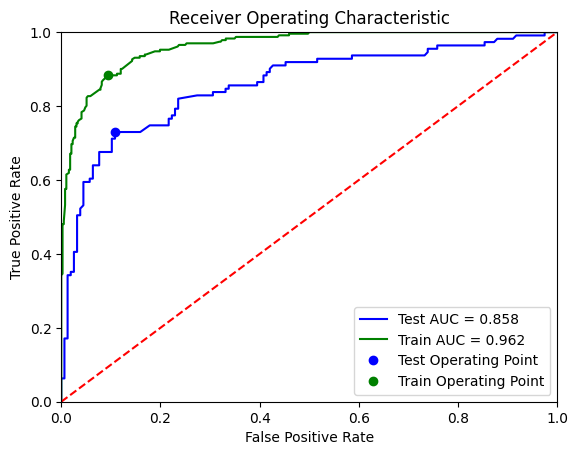

In [21]:
plt.title('Receiver Operating Characteristic')

plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' % test_roc_auc)
plt.plot(train_fpr, train_tpr, 'g', label = 'Train AUC = %0.3f' % train_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.plot(test_operating_point_fpr,test_operating_point_tpr, 'bo', label=f'Test Operating Point')
plt.plot(train_operating_point_fpr,train_operating_point_tpr, 'go', label=f'Train Operating Point')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()

In [28]:
print(test_threshold)

test_threshold = 0.7


df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > test_threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

print(df_test)

df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.boosting.csv", index=False)

0.7
     PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin  ...  \
0      male  34.5      0      0